## Exercise 1: Disparity

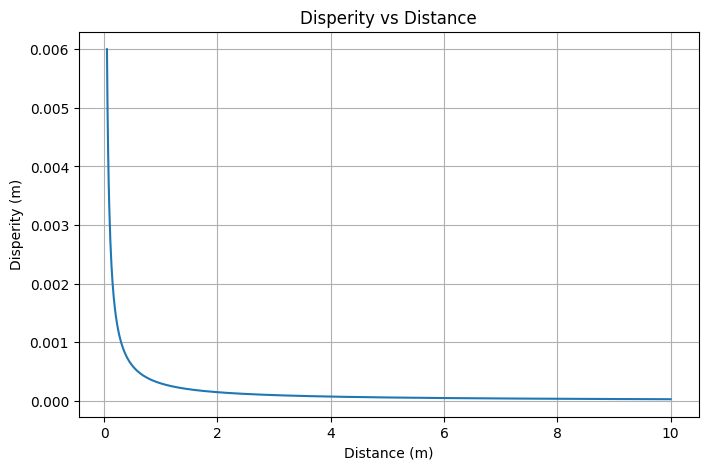

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import a5_utils
import cv2
from scipy.signal import medfilt

f = 0.0025
T = 0.12

pz = np.linspace(0.05, 10, 1000)

d = f * T / pz

plt.figure(figsize=(8, 5))
plt.plot(pz, d)
plt.title("Disperity vs Distance")
plt.xlabel("Distance (m)")
plt.ylabel("Disperity (m)")
plt.grid()
plt.show()

#### What is the relation between the distance of the object (point p in Figure 1) to the camera and the disparity d? What happens to disparity when the object is close to the cameras and what when it is far away?

d = f * T / pz

Disparity d is inversely proportional to the distance of the object to the camera. When the object is close to the cameras, the disparity is large, and when the object is far away, the disparity is small.


In [13]:
f = 0.0025
T = 0.12
pixel_width = 7.4e-6

x1_left = 550
x2_right1 = 300
x2_right2 = 540

def calculate_disparity_distance(f, T, x1, x2, pixel_width):
    d = (x1 - x2) * pixel_width
    pz = (f * T) / d # d = f * T / pz
    return pz, d

pz1, d1 = calculate_disparity_distance(f, T, x1_left, x2_right1, pixel_width)
pz2, d2 = calculate_disparity_distance(f, T, x1_left, x2_right2, pixel_width)

print("Prvi primer:")
print(f"Disparity: {d1:.6f} m")
print(f"Razdalja objekta: {pz1:.2f} m")

print("\nDrugi primer:")
print(f"Disparity: {d2:.6f} m")
print(f"Razdalja objekta: {pz2:.2f} m")


Prvi primer:
Disparity: 0.001850 m
Razdalja objekta: 0.16 m

Drugi primer:
Disparity: 0.000074 m
Razdalja objekta: 4.05 m


## Exercise 2: Fundamental matrix, epipoles, epipolar lines

In [28]:
F = np.array([
    [1, 0, 0],
    [0, 0.5, 0],
    [0, 0, -1]
])

points_left = [[0, 2, 1], [1, 0, 1]]

epipolar_lines = []
for point in points_left:
    line = F @ np.array(point)  # l' = F * x
    epipolar_lines.append(line)

for i, line in enumerate(epipolar_lines):
    print(f"Epipolarna črta za točko {points_left[i][:-1]}:")
    print(f"l' = {line[0]:.2f} * u' + {line[1]:.2f} * v' + {line[2]:.2f} -> [u', v', 1] * l' = 0")


Epipolarna črta za točko [0, 2]:
l' = 0.00 * u' + 1.00 * v' + -1.00 -> [u', v', 1] * l' = 0
Epipolarna črta za točko [1, 0]:
l' = 1.00 * u' + 0.00 * v' + -1.00 -> [u', v', 1] * l' = 0


F:
[[-8.85211824e-07 -5.61591880e-06  1.94310952e-03]
 [ 9.39281870e-06  6.16883199e-07 -1.20066302e-02]
 [-1.20308414e-03  1.10370070e-02 -8.53173359e-02]]

F correct:
[[-8.85211824e-07 -5.61591880e-06  1.94310952e-03]
 [ 9.39281870e-06  6.16883199e-07 -1.20066302e-02]
 [-1.20308414e-03  1.10370070e-02 -8.53173359e-02]]


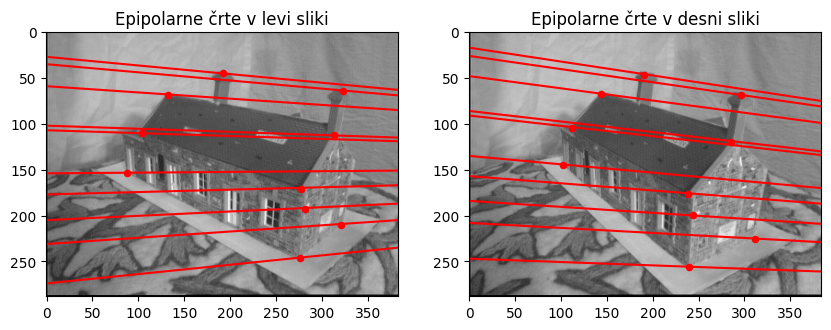

In [68]:
def fundamental_matrix(points):
    points_left = points[:, :2]
    points_right = points[:, 2:]

    normalized_left, T1 = a5_utils.normalize_points(points_left)
    normalized_right, T2 = a5_utils.normalize_points(points_right)

    A = []
    for (x1, y1), (x2, y2) in zip(normalized_left[:, :2], normalized_right[:, :2]):
        A.append([x1 * x2, x1 * y2, x1, y1 * x2, y1 * y2, y1, x2, y2, 1])
    A = np.array(A)

    _, _, Vt = np.linalg.svd(A)
    F_hat = Vt[-1].reshape(3, 3)

    U, S, Vt = np.linalg.svd(F_hat)
    S[-1] = 0
    F_hat = U @ np.diag(S) @ Vt

    F = T1.T @ F_hat @ T2
    return F.T


points = np.loadtxt('data/epipolar/house_points.txt')
F_correct = np.loadtxt('data/epipolar/house_fundamental.txt')

F = fundamental_matrix(points)
print("F:")
print(F)
print("\nF correct:")
print(F_correct)

points_left = points[:, :2]
points_right = points[:, 2:]

image_left = cv2.imread('data/epipolar/house1.jpg', cv2.IMREAD_GRAYSCALE)
image_right = cv2.imread('data/epipolar/house2.jpg', cv2.IMREAD_GRAYSCALE)
h, w = image_left.shape

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.imshow(image_left, cmap='gray')
plt.title('Epipolarne črte v levi sliki')

for point1, point2 in zip(points_left, points_right):
    line = F.T @ np.array([point2[0], point2[1], 1])
    a5_utils.draw_epiline(line, h, w)
    plt.scatter(point1[0], point1[1], color='red', s=20)

plt.subplot(1, 2, 2)
plt.imshow(image_right, cmap='gray')
plt.title('Epipolarne črte v desni sliki')

for point1, point2 in zip(points_left, points_right):
    line = F @ np.array([point1[0], point1[1], 1])
    a5_utils.draw_epiline(line, h, w)
    plt.scatter(point2[0], point2[1], color='red', s=20)

plt.show()


In [80]:
def reprojection_error(F, p1, p2):
    p1_hom = np.append(p1, 1)
    p2_hom = np.append(p2, 1)
    
    l2 = F @ p1_hom
    a, b, c = l2
    distance_2 = abs(a * p2[0] + b * p2[1] + c) / np.sqrt(a**2 + b**2)
    
    l1 = F.T @ p2_hom
    a, b, c = l1
    distance_1 = abs(a * p1[0] + b * p1[1] + c) / np.sqrt(a**2 + b**2)
    
    avg_error = (distance_1 + distance_2) / 2
    return avg_error

points = np.loadtxt('data/epipolar/house_points.txt')
F = fundamental_matrix(points)

p1 = np.array([85, 233])
p2 = np.array([67, 219])

error = reprojection_error(F, p1, p2)
print(f"Reprojection error: {error:.4f} pixels")

errors = []
for i in range(len(points)):
    p1 = points[i, :2]
    p2 = points[i, 2:]
    error = reprojection_error(F, p1, p2)
    errors.append(error)

average_error = np.average(errors)
print(f"Average reprojection error: {average_error:.4f} pixels")


Reprojection error: 0.1467 pixels
Average reprojection error: 0.3309 pixels
